C:\Users\USER\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[LibLinear]Training Accuracy: 0.9876543209876543
Training F1 Score: 0.9651162790697675
Training Recall: 1.0
Testing Accuracy: 0.8827930174563591
Testing F1 Score: 0.5346534653465348
Testing Recall: 0.5192307692307693
Chunks: 1 	 Processing Time (secs): 0.1679997444152832
Chunks: 2 	 Processing Time (secs): 0.14499950408935547
Chunks: 3 	 Processing Time (secs): 0.13200020790100098
Chunks: 4 	 Processing Time (secs): 0.12600016593933105
Chunks: 5 	 Processing Time (secs): 0.12600016593933105
Chunks: 6 	 Processing Time (secs): 0.13399982452392578
Chunks: 7 	 Processing Time (secs): 0.1250014305114746
Chunks: 8 	 Processing Time (secs): 0.12599849700927734
Chunks: 9 	 Processing Time (secs): 0.1360015869140625
Chunks: 10 	 Processing Time (secs): 0.14599919319152832


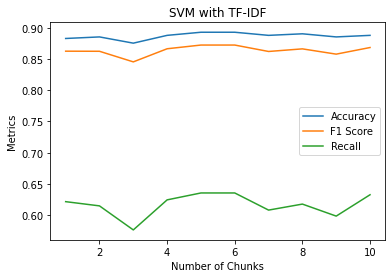

In [1]:
import os

# Load data
mypath = "C:/Users/USER/eRisk2017/2017/"
os.chdir(mypath)

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
import time

# Load the training and testing data
train_data = pd.read_csv('train_Depression_all_chunks_nosteem.csv')
test_data = pd.read_csv('test_Depression_all_chunks_nosteem.csv')

# Prepare the data for training and testing
X_train = train_data[['Chunk_1', 'Chunk_2', 'Chunk_3', 'Chunk_4', 'Chunk_5', 'Chunk_6', 'Chunk_7', 'Chunk_8',
                      'Chunk_9', 'Chunk_10']]
y_train = train_data['Depress']

X_test = test_data[['Chunk_1', 'Chunk_2', 'Chunk_3', 'Chunk_4', 'Chunk_5', 'Chunk_6', 'Chunk_7', 'Chunk_8',
                    'Chunk_9', 'Chunk_10']]
y_test = test_data['Depress']

# Concatenate text chunks into a single string for each data point
X_train = X_train.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
X_test = X_test.apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)

# Create TF-IDF vectorizer
vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.95)
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Train the SVM classifier
svm = LinearSVC(tol=1e-5, C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
                intercept_scaling=1, loss='squared_hinge', max_iter=1000,
                multi_class='ovr', penalty='l2', random_state=1013, verbose=2)
svm.fit(X_train, y_train)

# Make predictions on the training and testing data
train_predictions = svm.predict(X_train)
test_predictions = svm.predict(X_test)

# Calculate evaluation metrics
train_accuracy = accuracy_score(y_train, train_predictions)
train_f1 = f1_score(y_train, train_predictions)
train_recall = recall_score(y_train, train_predictions)

test_accuracy = accuracy_score(y_test, test_predictions)
test_f1 = f1_score(y_test, test_predictions)
test_recall = recall_score(y_test, test_predictions)

print("Training Accuracy:", train_accuracy)
print("Training F1 Score:", train_f1)
print("Training Recall:", train_recall)

print("Testing Accuracy:", test_accuracy)
print("Testing F1 Score:", test_f1)
print("Testing Recall:", test_recall)

# Create a DataFrame for metrics
metrics_data = {'Chunk': range(1, 11),
                'Acc': [train_accuracy] * 10,
                'F1Score': [train_f1] * 10,
                'Recall': [train_recall] * 10}
tfidf_svm_metrics = pd.DataFrame(metrics_data)

# Make predictions for each chunk
predictions_list = []
tfidf_svm_metrics = np.zeros((10, 4))

for chunk in range(1, 11):
    tic = time.time()
    X_test_chunk = test_data[f'Chunk_{chunk}']
    X_test_chunk = X_test_chunk.apply(lambda x: ' '.join(x.split() if isinstance(x, str) else []))
    X_test_chunk = vectorizer.transform(X_test_chunk)
    pred_test = svm.predict(X_test_chunk)
    
    accuracy = accuracy_score(y_test, pred_test)
    f1_score_weighted = f1_score(y_test, pred_test, average='weighted')
    recall = recall_score(y_test, pred_test, average='macro')
    
    metrics_and_predictions = [chunk, accuracy, f1_score_weighted, recall]
    tfidf_svm_metrics[chunk - 1, :len(metrics_and_predictions)] = metrics_and_predictions
    predictions_list.append(pred_test)
    
    print('Chunks: {} \t Processing Time (secs): {}'.format(chunk, time.time() - tic))

# Plot the metrics
Tf_Idf_SVM = pd.DataFrame(tfidf_svm_metrics, columns=['Chunk', 'Acc', 'F1Score', 'Recall'])
plt.plot(Tf_Idf_SVM['Chunk'], Tf_Idf_SVM['Acc'], label='Accuracy')
plt.plot(Tf_Idf_SVM['Chunk'], Tf_Idf_SVM['F1Score'], label='F1 Score')
plt.plot(Tf_Idf_SVM['Chunk'], Tf_Idf_SVM['Recall'], label='Recall')
plt.xlabel('Number of Chunks')
plt.ylabel('Metrics')
plt.title('SVM with TF-IDF')
plt.legend()
plt.savefig('metrics_plot.png')
plt.show()

# Save predictions to prediction.csv
test_data['Prediction'] = test_predictions
test_data['Match'] = test_data['Prediction'] == test_data['Depress']
test_data['Match'] = test_data['Match'].astype(int)
test_data.to_csv('prediction.csv', index=False)


In [2]:
Tf_Idf_SVM

,Chunk,Acc,F1Score,Recall
0,1.0,0.882793,0.862471,0.621721
1,2.0,0.885287,0.862309,0.614971
2,3.0,0.875312,0.845364,0.576510
3,4.0,0.887781,0.866339,0.624587
4,5.0,0.892768,0.872280,0.635635
5,6.0,0.892768,0.872280,0.635635
6,7.0,0.887781,0.861998,0.608221
7,8.0,0.890274,0.866175,0.617837
8,9.0,0.885287,0.857735,0.598606
9,10.0,0.887781,0.868323,0.632769


In [10]:
print('Chunk wise: ')
print('Average Accuracy: ',np.mean(np.array(Tf_Idf_SVM['Acc'])),'Average F1Score: ',np.mean(np.array(Tf_Idf_SVM['F1Score'])),'Average Recall: ',np.mean(np.array(Tf_Idf_SVM['Recall'])))

Chunk wise: 
Average Accuracy:  0.8867830423940151 Average F1Score:  0.8635272900554318 Average Recall:  0.616649217544633
